In [1]:
import pandas_datareader as pdr
from pandas_datareader.yahoo.headers import DEFAULT_HEADERS
import pandas as pd
import numpy as np
import datetime
import requests_cache

expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)
session.headers = DEFAULT_HEADERS

start = datetime.datetime(2020, 1, 2)
end = datetime.datetime(2021, 10, 12)
tickers = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'GOOG', 'TSLA', 'NVDA', 'BRK-B', 'JPM'] # 
weights = np.array([0.15, 0.1, 0.1, 0.1, 0.05, 0.05, 0.1, 0.15, 0.1, 0.1])
eq_weights = False
rebalance = True
fund_size = 1000000

if eq_weights:
    weights = np.ones(len(tickers)) * (1/len(tickers))

prices = pdr.yahoo.daily.YahooDailyReader(
    symbols=tickers,
    start=start,
    end=end,
    retry_count=3,
    pause=0.1,
    session=session,
    adjust_price=False,
    ret_index=False,
    chunksize=25,
    interval='d',
    get_actions=False,
    adjust_dividends=True).read()['Adj Close']
prices.index = pd.to_datetime(prices.index)
prices = prices.asfreq('B', method='ffill')

def calc_shares(prices, weights, fund_size):
        return pd.DataFrame(weights*fund_size/prices).round().transpose()

holdings = calc_shares(prices.iloc[0], weights, fund_size)

if rebalance:
    dates = pd.date_range(start=start, end=end, freq='BQ') # pd.DatetimeIndex([start]).append(pd.date_range(start=start, end=end, freq='BQ'))
    for i in range(dates.size):
        date = dates[i]
        fund_size = (holdings.iloc[i]*prices.loc[date-pd.offsets.BDay()]).sum()
        holdings = holdings.append(calc_shares(prices.loc[date], weights, fund_size))

holdings = holdings.append(pd.DataFrame([holdings.iloc[-1].values], columns=holdings.columns, index=pd.DatetimeIndex([end])))
holdings = holdings.asfreq('B', method='ffill')

values = holdings*prices
fund_value = values.sum(axis=1)

<AxesSubplot:>

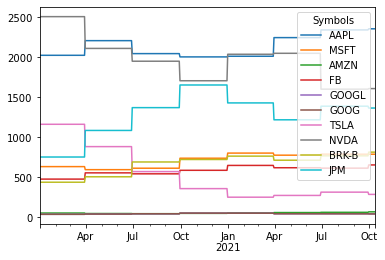

In [2]:
holdings.plot()

<AxesSubplot:>

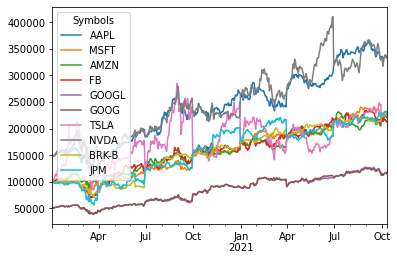

In [3]:
values.plot()

<AxesSubplot:>

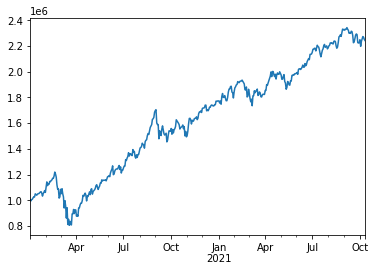

In [4]:
fund_value.plot()